In [1]:
import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, TensorDataset, Subset
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path


In [2]:
#hyper params
dataset_path = './data/binary_dataset/data'

bs = 64
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 500
patience = 20
classes = ['IRRELEVANT', 'RELEVANT'] #arranged in order of their placement in the folder
num_classes = len(classes)


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [5]:
def subsample(dataset, r=0.):
    # Get the labels for the dataset
    labels = np.asarray(dataset.dataset.imgs)[:, 1][dataset.indices]

    # Count the number of samples per class
    class_counts = defaultdict(int)
    for label in labels:
        class_counts[label] += 1

    # Calculate m
    m = min(class_counts.values())

    # Calculate the threshold for each class
    threshold = m + r * m

    # Create a new subset of the dataset
    indices = []
    new_class_counts = defaultdict(int)
    for i in range(len(dataset)):
        label = labels[i]
        if new_class_counts[label] < threshold:
            indices.append(i)
            new_class_counts[label] += 1

    return Subset(dataset, indices)

In [6]:
def get_dataset(path,val_split,test_split):
    transform_train = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
    transform_test = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset = datasets.ImageFolder(path)    
    trainset,valset,testset = stratified(dataset, r=.0)

    trainset = DatasetFromSubset(trainset, transform=transform_train)
    valset = DatasetFromSubset(valset, transform=transform_test)
    testset = DatasetFromSubset(testset, transform=transform_test)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))
    
    return trainset,valset,testset


In [7]:
def write_indices(indices, images, name):
    file_list = np.asarray(images)[indices]

    with open(Path(dataset_path) / (name + '.txt'), 'w') as f:
        f.writelines(file_list)


def stratified(dataset, r=0.):
    # Get the labels and targets from the dataset
    labels = np.asarray(dataset.imgs)[:, 1]

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(np.zeros(len(labels)), labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)

    # write down the splits
    imgs = [img[0] + '\n' for img in dataset.imgs]
    write_indices(train_val_indices, imgs, "train_images")
    write_indices(test_indices, imgs, "test_images")
    with open(Path(dataset_path) / "all_images.txt", "w") as f:
        f.writelines(imgs)

    # balance the train set
    train_val_dataset = subsample(train_val_dataset, r=r)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, labels[train_val_indices][train_val_dataset.indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)

    return trainset,valset,testset

In [8]:
# trainset, valset, testset = get_dataset(Path(dataset_path) / 'data', val_size, test_size)

In [9]:
def entropy(tensor):
    probabilities = torch.softmax(tensor, dim=1)
    log_prob = torch.log2(torch.min(torch.ones_like(probabilities), probabilities + 1e-10)) / math.log2(tensor.shape[-1])
    return -torch.sum(probabilities * log_prob, dim=1)

In [10]:
def train_model(trainset,valset, model, criterion, optimizer, num_epochs, bs):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epoch, steps_per_epoch=len(dataloaders_strong['train']), max_lr=0.1)
    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders_strong[phase], "Running " + phase):
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=UserWarning)
                        
                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(preds.cpu().tolist())

                    # Backpropagation and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()   
                        scheduler.step()               
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                e = entropy(outputs)
                epoch_entropy += torch.sum(e)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy

                
                # print('Number of skipped:', c)
                # print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.cpu().item())
                E_loss_train.append(epoch_loss)
                E_accuracy_train.append(epoch_acc.cpu().item())
            else:
                entropy_values_val.append(epoch_entropy.cpu().item())
                E_loss_val.append(epoch_loss)
                E_accuracy_val.append(epoch_acc.cpu().item())
                      
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                best_acc = epoch_acc
                
                
            # Early stopping criteria
            if phase == 'val' and epoch_loss <= 1e-7:
                    print('Loss reached 0...')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        E_accuracy_train,
                        E_accuracy_val
                    ) 
                    
            if phase == 'val' and epoch > 0:

                if epoch_loss >= best_loss:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        E_accuracy_train,
                        E_accuracy_val
                    )                 

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [11]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    all_confidences = []
    c = 0
    confidence_scores_distribution = []
    model.eval()
    
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate confidence score for each sample in the batch
            confidence_scores = 1 - entropy(outputs)
                
            # running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_confidences.extend(confidence_scores.cpu().tolist())

    return np.asarray(all_labels), np.asarray(all_preds), np.asarray(all_confidences)

In [12]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [13]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [14]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [15]:
def plot_distribution_by_class(subset):
    if isinstance(subset.subset.dataset, Subset):
        # validation and train sets
        data_ = subset.subset.dataset.dataset.dataset
        labels = np.asarray(data_.imgs)[subset.subset.dataset.dataset.indices]
        labels = labels[subset.subset.dataset.indices]
        labels = labels[subset.subset.indices, 1]
    else:
        # test set (two subsets less)
        data_ = subset.subset.dataset
        labels = np.asarray(data_.imgs)[subset.subset.indices, 1]
        
    classes = data_.classes
    labels, count = np.unique(np.asarray(labels), return_counts=True)
    labels = np.asarray([classes[int(i)] for i in labels])

    plt.figure(figsize=(10, 6))  # Set the size of the figure

    x = np.arange(len(labels))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, labels, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [16]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(dataset_path, val_size, test_size)

train : 37640 val : 9410 test : 29724


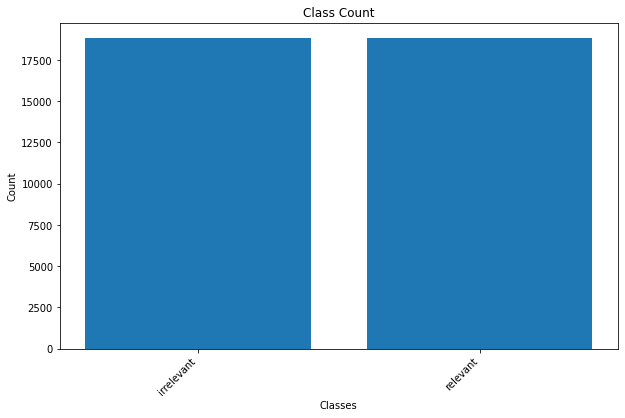

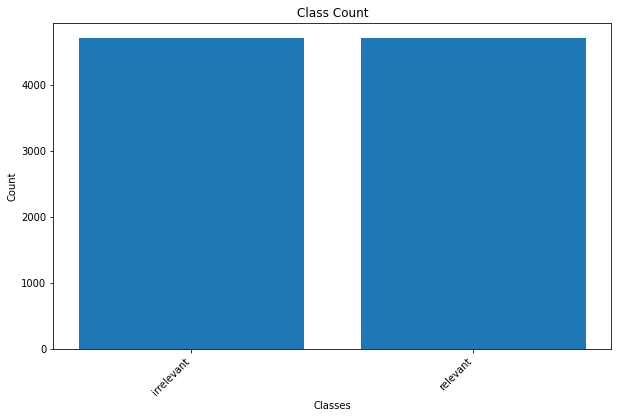

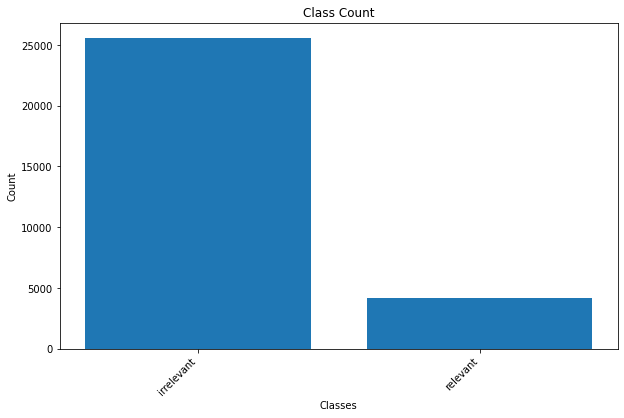

In [17]:
plot_distribution_by_class(trainset)
plot_distribution_by_class(valset)
plot_distribution_by_class(testset)

In [18]:
def train_model_name(model_name):
    print(model_name)
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters())
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, E_accuracy_train,E_accuracy_val = train_model(
        trainset,valset,model, criterion, optimizer, num_epoch, bs)

        
    # Plot entropy values
    plt.figure()
    plt.plot(entropy_values_train, label='Train')
    plt.plot(entropy_values_val, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Entropy')
    plt.title('Entropy Trend')
    plt.legend()
    plt.show()
    
    # Plot loss values
    plt.figure()
    plt.plot(E_loss_train, label='Train')
    plt.plot(E_loss_val, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trend')
    plt.legend()
    plt.show()
    
    # Plot balanced loss values
    plt.figure()
    plt.plot(E_accuracy_train, label='Train')
    plt.plot(E_accuracy_val, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Trend')
    plt.legend()
    plt.show()

    return model

In [19]:
model_list = []
model_list.append(train_model_name('densenet'))

densenet


/home/federico/omr/__pypackages__/3.9/lib/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/omr/__pypackages__/3.9/lib/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/499
----------


Running train:   0%|                                                                                                                    | 0/589 [00:00<?, ?it/s]

Running train:   0%|▏                                                                                                           | 1/589 [00:01<12:37,  1.29s/it]

Running train:   0%|▎                                                                                                           | 2/589 [00:02<09:33,  1.02it/s]

Running train:   1%|▌                                                                                                           | 3/589 [00:02<08:53,  1.10it/s]

Running train:   1%|▋                                                                                                           | 4/589 [00:03<08:12,  1.19it/s]

Running train:   1%|▉                                                                                                           | 5/589 [00:04<07:59,  1.22it/s]

Running train:   1%|█                                                                                                           | 6/589 [00:05<07:49,  1.24it/s]

Running train:   1%|█▎                                                                                                          | 7/589 [00:05<07:34,  1.28it/s]

Running train:   1%|█▍                                                                                                          | 8/589 [00:06<07:25,  1.30it/s]

Running train:   2%|█▋                                                                                                          | 9/589 [00:07<07:18,  1.32it/s]

Running train:   2%|█▊                                                                                                         | 10/589 [00:08<07:20,  1.32it/s]

Running train:   2%|█▉                                                                                                         | 11/589 [00:08<07:17,  1.32it/s]

Running train:   2%|██▏                                                                                                        | 12/589 [00:09<07:20,  1.31it/s]

Running train:   2%|██▎                                                                                                        | 13/589 [00:10<07:19,  1.31it/s]

Running train:   2%|██▌                                                                                                        | 14/589 [00:11<07:10,  1.34it/s]

Running train:   3%|██▋                                                                                                        | 15/589 [00:11<07:03,  1.36it/s]

Running train:   3%|██▉                                                                                                        | 16/589 [00:12<06:59,  1.37it/s]

Running train:   3%|███                                                                                                        | 17/589 [00:13<06:56,  1.37it/s]

Running train:   3%|███▎                                                                                                       | 18/589 [00:14<06:57,  1.37it/s]

Running train:   3%|███▍                                                                                                       | 19/589 [00:14<06:56,  1.37it/s]

Running train:   3%|███▋                                                                                                       | 20/589 [00:15<06:54,  1.37it/s]

Running train:   4%|███▊                                                                                                       | 21/589 [00:16<07:04,  1.34it/s]

Running train:   4%|███▉                                                                                                       | 22/589 [00:17<07:03,  1.34it/s]

Running train:   4%|████▏                                                                                                      | 23/589 [00:17<07:07,  1.32it/s]

Running train:   4%|████▎                                                                                                      | 24/589 [00:18<07:13,  1.30it/s]

Running train:   4%|████▌                                                                                                      | 25/589 [00:19<07:15,  1.30it/s]

Running train:   4%|████▋                                                                                                      | 26/589 [00:20<07:08,  1.32it/s]

Running train:   5%|████▉                                                                                                      | 27/589 [00:20<06:55,  1.35it/s]

Running train:   5%|█████                                                                                                      | 28/589 [00:21<06:53,  1.36it/s]

Running train:   5%|█████▎                                                                                                     | 29/589 [00:22<06:51,  1.36it/s]

Running train:   5%|█████▍                                                                                                     | 30/589 [00:23<06:56,  1.34it/s]

Running train:   5%|█████▋                                                                                                     | 31/589 [00:23<06:55,  1.34it/s]

Running train:   5%|█████▊                                                                                                     | 32/589 [00:24<07:03,  1.31it/s]

Running train:   6%|█████▉                                                                                                     | 33/589 [00:25<07:07,  1.30it/s]

Running train:   6%|██████▏                                                                                                    | 34/589 [00:26<07:07,  1.30it/s]

Running train:   6%|██████▎                                                                                                    | 35/589 [00:26<07:00,  1.32it/s]

Running train:   6%|██████▌                                                                                                    | 36/589 [00:27<07:02,  1.31it/s]

Running train:   6%|██████▋                                                                                                    | 37/589 [00:28<07:05,  1.30it/s]

Running train:   6%|██████▉                                                                                                    | 38/589 [00:29<07:15,  1.27it/s]

Running train:   7%|███████                                                                                                    | 39/589 [00:29<07:03,  1.30it/s]

Running train:   7%|███████▎                                                                                                   | 40/589 [00:30<06:58,  1.31it/s]

Running train:   7%|███████▍                                                                                                   | 41/589 [00:31<06:58,  1.31it/s]

Running train:   7%|███████▋                                                                                                   | 42/589 [00:32<07:00,  1.30it/s]

Running train:   7%|███████▊                                                                                                   | 43/589 [00:33<07:01,  1.29it/s]

Running train:   7%|███████▉                                                                                                   | 44/589 [00:33<07:04,  1.28it/s]

Running train:   8%|████████▏                                                                                                  | 45/589 [00:34<07:08,  1.27it/s]

Running train:   8%|████████▎                                                                                                  | 46/589 [00:35<07:07,  1.27it/s]

Running train:   8%|████████▌                                                                                                  | 47/589 [00:36<07:05,  1.27it/s]

Running train:   8%|████████▋                                                                                                  | 48/589 [00:37<07:08,  1.26it/s]

Running train:   8%|████████▉                                                                                                  | 49/589 [00:37<07:11,  1.25it/s]

Running train:   8%|█████████                                                                                                  | 50/589 [00:38<07:08,  1.26it/s]

Running train:   9%|█████████▎                                                                                                 | 51/589 [00:39<07:05,  1.26it/s]

Running train:   9%|█████████▍                                                                                                 | 52/589 [00:40<07:08,  1.25it/s]

Running train:   9%|█████████▋                                                                                                 | 53/589 [00:41<07:04,  1.26it/s]

Running train:   9%|█████████▊                                                                                                 | 54/589 [00:41<06:53,  1.29it/s]

Running train:   9%|█████████▉                                                                                                 | 55/589 [00:42<06:49,  1.30it/s]

Running train:  10%|██████████▏                                                                                                | 56/589 [00:43<06:50,  1.30it/s]

Running train:  10%|██████████▎                                                                                                | 57/589 [00:44<06:51,  1.29it/s]

Running train:  10%|██████████▌                                                                                                | 58/589 [00:44<06:54,  1.28it/s]

Running train:  10%|██████████▋                                                                                                | 59/589 [00:45<06:56,  1.27it/s]

Running train:  10%|██████████▉                                                                                                | 60/589 [00:46<06:55,  1.27it/s]

Running train:  10%|███████████                                                                                                | 61/589 [00:47<06:54,  1.27it/s]

Running train:  11%|███████████▎                                                                                               | 62/589 [00:47<06:51,  1.28it/s]

Running train:  11%|███████████▍                                                                                               | 63/589 [00:48<06:51,  1.28it/s]

Running train:  11%|███████████▋                                                                                               | 64/589 [00:49<06:43,  1.30it/s]

Running train:  11%|███████████▊                                                                                               | 65/589 [00:50<06:42,  1.30it/s]

Running train:  11%|███████████▉                                                                                               | 66/589 [00:51<06:46,  1.29it/s]

Running train:  11%|████████████▏                                                                                              | 67/589 [00:51<06:55,  1.26it/s]

Running train:  12%|████████████▎                                                                                              | 68/589 [00:52<06:45,  1.29it/s]

Running train:  12%|████████████▌                                                                                              | 69/589 [00:53<06:42,  1.29it/s]

Running train:  12%|████████████▋                                                                                              | 70/589 [00:54<06:41,  1.29it/s]

Running train:  12%|████████████▉                                                                                              | 71/589 [00:54<06:40,  1.29it/s]

Running train:  12%|█████████████                                                                                              | 72/589 [00:55<06:52,  1.25it/s]

Running train:  12%|█████████████▎                                                                                             | 73/589 [00:56<06:41,  1.28it/s]

Running train:  13%|█████████████▍                                                                                             | 74/589 [00:57<06:39,  1.29it/s]

Running train:  13%|█████████████▌                                                                                             | 75/589 [00:58<06:38,  1.29it/s]

Running train:  13%|█████████████▊                                                                                             | 76/589 [00:58<06:38,  1.29it/s]

Running train:  13%|█████████████▉                                                                                             | 77/589 [00:59<06:38,  1.28it/s]

Running train:  13%|██████████████▏                                                                                            | 78/589 [01:00<06:36,  1.29it/s]

Running train:  13%|██████████████▎                                                                                            | 79/589 [01:01<06:27,  1.32it/s]

Running train:  14%|██████████████▌                                                                                            | 80/589 [01:01<06:24,  1.33it/s]

Running train:  14%|██████████████▋                                                                                            | 81/589 [01:02<06:25,  1.32it/s]

Running train:  14%|██████████████▉                                                                                            | 82/589 [01:03<06:36,  1.28it/s]

Running train:  14%|███████████████                                                                                            | 83/589 [01:04<06:30,  1.30it/s]

Running train:  14%|███████████████▎                                                                                           | 84/589 [01:05<06:28,  1.30it/s]

Running train:  14%|███████████████▍                                                                                           | 85/589 [01:05<06:31,  1.29it/s]

Running train:  15%|███████████████▌                                                                                           | 86/589 [01:06<06:29,  1.29it/s]

Running train:  15%|███████████████▊                                                                                           | 87/589 [01:07<06:34,  1.27it/s]

Running train:  15%|███████████████▉                                                                                           | 88/589 [01:08<06:21,  1.31it/s]

Running train:  15%|████████████████▏                                                                                          | 89/589 [01:08<06:16,  1.33it/s]

Running train:  15%|████████████████▎                                                                                          | 90/589 [01:09<06:18,  1.32it/s]

Running train:  15%|████████████████▌                                                                                          | 91/589 [01:10<06:17,  1.32it/s]

Running train:  16%|████████████████▋                                                                                          | 92/589 [01:11<06:18,  1.31it/s]

Running train:  16%|████████████████▉                                                                                          | 93/589 [01:11<06:19,  1.31it/s]

Running train:  16%|█████████████████                                                                                          | 94/589 [01:12<06:24,  1.29it/s]

Running train:  16%|█████████████████▎                                                                                         | 95/589 [01:13<06:22,  1.29it/s]

Running train:  16%|█████████████████▍                                                                                         | 96/589 [01:14<06:22,  1.29it/s]

Running train:  16%|█████████████████▌                                                                                         | 97/589 [01:15<06:20,  1.29it/s]

Running train:  17%|█████████████████▊                                                                                         | 98/589 [01:15<06:18,  1.30it/s]

Running train:  17%|█████████████████▉                                                                                         | 99/589 [01:16<06:13,  1.31it/s]

Running train:  17%|█████████████████▉                                                                                        | 100/589 [01:17<06:15,  1.30it/s]

Running train:  17%|██████████████████▏                                                                                       | 101/589 [01:18<06:17,  1.29it/s]

Running train:  17%|██████████████████▎                                                                                       | 102/589 [01:18<06:20,  1.28it/s]

Running train:  17%|██████████████████▌                                                                                       | 103/589 [01:19<06:19,  1.28it/s]

Running train:  18%|██████████████████▋                                                                                       | 104/589 [01:20<06:12,  1.30it/s]

Running train:  18%|██████████████████▉                                                                                       | 105/589 [01:21<06:09,  1.31it/s]

Running train:  18%|███████████████████                                                                                       | 106/589 [01:21<06:11,  1.30it/s]

Running train:  18%|███████████████████▎                                                                                      | 107/589 [01:22<06:13,  1.29it/s]

Running train:  18%|███████████████████▍                                                                                      | 108/589 [01:23<06:14,  1.29it/s]

Running train:  19%|███████████████████▌                                                                                      | 109/589 [01:24<06:13,  1.29it/s]

Running train:  19%|███████████████████▊                                                                                      | 110/589 [01:25<06:09,  1.30it/s]

Running train:  19%|███████████████████▉                                                                                      | 111/589 [01:25<06:08,  1.30it/s]

Running train:  19%|████████████████████▏                                                                                     | 112/589 [01:26<06:12,  1.28it/s]

Running train:  19%|████████████████████▎                                                                                     | 113/589 [01:27<06:10,  1.28it/s]

Running train:  19%|████████████████████▌                                                                                     | 114/589 [01:28<06:09,  1.29it/s]

Running train:  20%|████████████████████▋                                                                                     | 115/589 [01:28<06:06,  1.29it/s]

Running train:  20%|████████████████████▉                                                                                     | 116/589 [01:29<06:08,  1.28it/s]

Running train:  20%|█████████████████████                                                                                     | 117/589 [01:30<06:07,  1.28it/s]

Running train:  20%|█████████████████████▏                                                                                    | 118/589 [01:31<06:11,  1.27it/s]

Running train:  20%|█████████████████████▍                                                                                    | 119/589 [01:32<06:10,  1.27it/s]

Running train:  20%|█████████████████████▌                                                                                    | 120/589 [01:32<06:10,  1.27it/s]

Running train:  21%|█████████████████████▊                                                                                    | 121/589 [01:33<06:02,  1.29it/s]

Running train:  21%|█████████████████████▉                                                                                    | 122/589 [01:34<06:00,  1.30it/s]

Running train:  21%|██████████████████████▏                                                                                   | 123/589 [01:35<06:01,  1.29it/s]

Running train:  21%|██████████████████████▎                                                                                   | 124/589 [01:35<06:04,  1.28it/s]

Running train:  21%|██████████████████████▍                                                                                   | 125/589 [01:36<06:06,  1.27it/s]

Running train:  21%|██████████████████████▋                                                                                   | 126/589 [01:37<06:05,  1.27it/s]

Running train:  22%|██████████████████████▊                                                                                   | 127/589 [01:38<06:05,  1.26it/s]

Running train:  22%|███████████████████████                                                                                   | 128/589 [01:39<06:04,  1.26it/s]

Running train:  22%|███████████████████████▏                                                                                  | 129/589 [01:39<06:06,  1.26it/s]

Running train:  22%|███████████████████████▍                                                                                  | 130/589 [01:40<06:02,  1.27it/s]

Running train:  22%|███████████████████████▌                                                                                  | 131/589 [01:41<06:02,  1.26it/s]

Running train:  22%|███████████████████████▊                                                                                  | 132/589 [01:42<06:02,  1.26it/s]

Running train:  23%|███████████████████████▉                                                                                  | 133/589 [01:43<06:04,  1.25it/s]

Running train:  23%|████████████████████████                                                                                  | 134/589 [01:43<06:04,  1.25it/s]

Running train:  23%|████████████████████████▎                                                                                 | 135/589 [01:44<05:52,  1.29it/s]

Running train:  23%|████████████████████████▍                                                                                 | 136/589 [01:45<05:42,  1.32it/s]

Running train:  23%|████████████████████████▋                                                                                 | 137/589 [01:46<05:41,  1.32it/s]

Running train:  23%|████████████████████████▊                                                                                 | 138/589 [01:46<05:40,  1.32it/s]

Running train:  24%|█████████████████████████                                                                                 | 139/589 [01:47<05:38,  1.33it/s]

Running train:  24%|█████████████████████████▏                                                                                | 140/589 [01:48<05:40,  1.32it/s]

Running train:  24%|█████████████████████████▍                                                                                | 141/589 [01:49<05:44,  1.30it/s]

Running train:  24%|█████████████████████████▌                                                                                | 142/589 [01:50<05:46,  1.29it/s]

Running train:  24%|█████████████████████████▋                                                                                | 143/589 [01:50<05:46,  1.29it/s]

Running train:  24%|█████████████████████████▉                                                                                | 144/589 [01:51<05:48,  1.28it/s]

Running train:  25%|██████████████████████████                                                                                | 145/589 [01:52<05:52,  1.26it/s]

Running train:  25%|██████████████████████████▎                                                                               | 146/589 [01:53<05:54,  1.25it/s]

Running train:  25%|██████████████████████████▍                                                                               | 147/589 [01:54<05:55,  1.24it/s]

Running train:  25%|██████████████████████████▋                                                                               | 148/589 [01:54<05:53,  1.25it/s]

Running train:  25%|██████████████████████████▊                                                                               | 149/589 [01:55<05:50,  1.25it/s]

Running train:  25%|██████████████████████████▉                                                                               | 150/589 [01:56<05:53,  1.24it/s]

Running train:  26%|███████████████████████████▏                                                                              | 151/589 [01:57<05:52,  1.24it/s]

Running train:  26%|███████████████████████████▎                                                                              | 152/589 [01:58<05:57,  1.22it/s]

Running train:  26%|███████████████████████████▌                                                                              | 153/589 [01:58<05:56,  1.22it/s]

Running train:  26%|███████████████████████████▋                                                                              | 154/589 [01:59<05:53,  1.23it/s]

Running train:  26%|███████████████████████████▉                                                                              | 155/589 [02:00<05:53,  1.23it/s]

Running train:  26%|████████████████████████████                                                                              | 156/589 [02:01<05:48,  1.24it/s]

Running train:  27%|████████████████████████████▎                                                                             | 157/589 [02:02<05:46,  1.25it/s]

Running train:  27%|████████████████████████████▍                                                                             | 158/589 [02:02<05:42,  1.26it/s]

Running train:  27%|████████████████████████████▌                                                                             | 159/589 [02:03<05:46,  1.24it/s]

Running train:  27%|████████████████████████████▊                                                                             | 160/589 [02:04<05:47,  1.24it/s]

Running train:  27%|████████████████████████████▉                                                                             | 161/589 [02:05<05:45,  1.24it/s]

Running train:  28%|█████████████████████████████▏                                                                            | 162/589 [02:06<05:42,  1.25it/s]

Running train:  28%|█████████████████████████████▎                                                                            | 163/589 [02:06<05:48,  1.22it/s]

Running train:  28%|█████████████████████████████▌                                                                            | 164/589 [02:07<05:43,  1.24it/s]

Running train:  28%|█████████████████████████████▋                                                                            | 165/589 [02:08<05:46,  1.22it/s]

Running train:  28%|█████████████████████████████▊                                                                            | 166/589 [02:09<05:57,  1.18it/s]

Running train:  28%|██████████████████████████████                                                                            | 167/589 [02:10<06:08,  1.15it/s]

Running train:  29%|██████████████████████████████▏                                                                           | 168/589 [02:11<06:01,  1.17it/s]

Running train:  29%|██████████████████████████████▍                                                                           | 169/589 [02:12<05:50,  1.20it/s]

Running train:  29%|██████████████████████████████▌                                                                           | 170/589 [02:12<05:47,  1.21it/s]

Running train:  29%|██████████████████████████████▊                                                                           | 171/589 [02:13<05:41,  1.22it/s]

Running train:  29%|██████████████████████████████▉                                                                           | 172/589 [02:14<05:39,  1.23it/s]

Running train:  29%|███████████████████████████████▏                                                                          | 173/589 [02:15<05:38,  1.23it/s]

Running train:  30%|███████████████████████████████▎                                                                          | 174/589 [02:16<05:35,  1.24it/s]

Running train:  30%|███████████████████████████████▍                                                                          | 175/589 [02:16<05:37,  1.23it/s]

Running train:  30%|███████████████████████████████▋                                                                          | 176/589 [02:17<05:32,  1.24it/s]

Running train:  30%|███████████████████████████████▊                                                                          | 177/589 [02:18<05:29,  1.25it/s]

Running train:  30%|████████████████████████████████                                                                          | 178/589 [02:19<05:28,  1.25it/s]

Running train:  30%|████████████████████████████████▏                                                                         | 179/589 [02:20<05:29,  1.24it/s]

Running train:  31%|████████████████████████████████▍                                                                         | 180/589 [02:20<05:30,  1.24it/s]

Running train:  31%|████████████████████████████████▌                                                                         | 181/589 [02:21<05:27,  1.25it/s]

Running train:  31%|████████████████████████████████▊                                                                         | 182/589 [02:22<05:42,  1.19it/s]

Running train:  31%|████████████████████████████████▉                                                                         | 183/589 [02:23<05:36,  1.21it/s]

Running train:  31%|█████████████████████████████████                                                                         | 184/589 [02:24<05:34,  1.21it/s]

Running train:  31%|█████████████████████████████████▎                                                                        | 185/589 [02:25<05:27,  1.23it/s]

Running train:  32%|█████████████████████████████████▍                                                                        | 186/589 [02:25<05:22,  1.25it/s]

Running train:  32%|█████████████████████████████████▋                                                                        | 187/589 [02:26<05:20,  1.25it/s]

Running train:  32%|█████████████████████████████████▊                                                                        | 188/589 [02:27<05:20,  1.25it/s]

Running train:  32%|██████████████████████████████████                                                                        | 189/589 [02:28<05:20,  1.25it/s]

Running train:  32%|██████████████████████████████████▏                                                                       | 190/589 [02:28<05:19,  1.25it/s]

Running train:  32%|██████████████████████████████████▎                                                                       | 191/589 [02:29<05:17,  1.25it/s]

Running train:  33%|██████████████████████████████████▌                                                                       | 192/589 [02:30<05:20,  1.24it/s]

Running train:  33%|██████████████████████████████████▋                                                                       | 193/589 [02:31<05:17,  1.25it/s]

Running train:  33%|██████████████████████████████████▉                                                                       | 194/589 [02:32<05:15,  1.25it/s]

Running train:  33%|███████████████████████████████████                                                                       | 195/589 [02:32<05:13,  1.26it/s]

Running train:  33%|███████████████████████████████████▎                                                                      | 196/589 [02:33<05:09,  1.27it/s]

Running train:  33%|███████████████████████████████████▍                                                                      | 197/589 [02:34<05:08,  1.27it/s]

Running train:  34%|███████████████████████████████████▋                                                                      | 198/589 [02:35<05:05,  1.28it/s]

Running train:  34%|███████████████████████████████████▊                                                                      | 199/589 [02:36<05:07,  1.27it/s]

Running train:  34%|███████████████████████████████████▉                                                                      | 200/589 [02:36<05:06,  1.27it/s]

Running train:  34%|████████████████████████████████████▏                                                                     | 201/589 [02:37<05:06,  1.27it/s]

Running train:  34%|████████████████████████████████████▎                                                                     | 202/589 [02:38<05:07,  1.26it/s]

Running train:  34%|████████████████████████████████████▌                                                                     | 203/589 [02:39<05:07,  1.25it/s]

Running train:  35%|████████████████████████████████████▋                                                                     | 204/589 [02:40<05:05,  1.26it/s]

Running train:  35%|████████████████████████████████████▉                                                                     | 205/589 [02:40<05:03,  1.26it/s]

Running train:  35%|█████████████████████████████████████                                                                     | 206/589 [02:41<05:04,  1.26it/s]

Running train:  35%|█████████████████████████████████████▎                                                                    | 207/589 [02:42<05:02,  1.26it/s]

Running train:  35%|█████████████████████████████████████▍                                                                    | 208/589 [02:43<05:01,  1.27it/s]

Running train:  35%|█████████████████████████████████████▌                                                                    | 209/589 [02:44<05:03,  1.25it/s]

Running train:  36%|█████████████████████████████████████▊                                                                    | 210/589 [02:44<04:58,  1.27it/s]

Running train:  36%|█████████████████████████████████████▉                                                                    | 211/589 [02:45<04:55,  1.28it/s]

Running train:  36%|██████████████████████████████████████▏                                                                   | 212/589 [02:46<04:55,  1.28it/s]

Running train:  36%|██████████████████████████████████████▎                                                                   | 213/589 [02:47<04:49,  1.30it/s]

Running train:  36%|██████████████████████████████████████▌                                                                   | 214/589 [02:47<04:45,  1.31it/s]

Running train:  37%|██████████████████████████████████████▋                                                                   | 215/589 [02:48<04:40,  1.34it/s]

Running train:  37%|██████████████████████████████████████▊                                                                   | 216/589 [02:49<04:46,  1.30it/s]

Running train:  37%|███████████████████████████████████████                                                                   | 217/589 [02:50<04:46,  1.30it/s]

Running train:  37%|███████████████████████████████████████▏                                                                  | 218/589 [02:50<04:48,  1.29it/s]

Running train:  37%|███████████████████████████████████████▍                                                                  | 219/589 [02:51<04:46,  1.29it/s]

Running train:  37%|███████████████████████████████████████▌                                                                  | 220/589 [02:52<04:46,  1.29it/s]

Running train:  38%|███████████████████████████████████████▊                                                                  | 221/589 [02:53<04:44,  1.29it/s]

Running train:  38%|███████████████████████████████████████▉                                                                  | 222/589 [02:53<04:36,  1.33it/s]

Running train:  38%|████████████████████████████████████████▏                                                                 | 223/589 [02:54<04:39,  1.31it/s]

Running train:  38%|████████████████████████████████████████▎                                                                 | 224/589 [02:55<04:41,  1.30it/s]

Running train:  38%|████████████████████████████████████████▍                                                                 | 225/589 [02:56<04:31,  1.34it/s]

Running train:  38%|████████████████████████████████████████▋                                                                 | 226/589 [02:57<04:38,  1.30it/s]

Running train:  39%|████████████████████████████████████████▊                                                                 | 227/589 [02:57<04:32,  1.33it/s]

Running train:  39%|█████████████████████████████████████████                                                                 | 228/589 [02:58<04:32,  1.32it/s]

Running train:  39%|█████████████████████████████████████████▏                                                                | 229/589 [02:59<04:38,  1.29it/s]

Running train:  39%|█████████████████████████████████████████▍                                                                | 230/589 [03:00<04:31,  1.32it/s]

Running train:  39%|█████████████████████████████████████████▌                                                                | 231/589 [03:00<04:33,  1.31it/s]

Running train:  39%|█████████████████████████████████████████▊                                                                | 232/589 [03:01<04:33,  1.31it/s]

Running train:  40%|█████████████████████████████████████████▉                                                                | 233/589 [03:02<04:31,  1.31it/s]

Running train:  40%|██████████████████████████████████████████                                                                | 234/589 [03:03<04:32,  1.30it/s]

Running train:  40%|██████████████████████████████████████████▎                                                               | 235/589 [03:03<04:32,  1.30it/s]

Running train:  40%|██████████████████████████████████████████▍                                                               | 236/589 [03:04<04:24,  1.33it/s]

Running train:  40%|██████████████████████████████████████████▋                                                               | 237/589 [03:05<04:22,  1.34it/s]

Running train:  40%|██████████████████████████████████████████▊                                                               | 238/589 [03:06<04:25,  1.32it/s]

Running train:  41%|███████████████████████████████████████████                                                               | 239/589 [03:06<04:25,  1.32it/s]

Running train:  41%|███████████████████████████████████████████▏                                                              | 240/589 [03:07<04:27,  1.31it/s]

Running train:  41%|███████████████████████████████████████████▎                                                              | 241/589 [03:08<04:30,  1.29it/s]

Running train:  41%|███████████████████████████████████████████▌                                                              | 242/589 [03:09<04:30,  1.28it/s]

Running train:  41%|███████████████████████████████████████████▋                                                              | 243/589 [03:10<04:32,  1.27it/s]

Running train:  41%|███████████████████████████████████████████▉                                                              | 244/589 [03:10<04:34,  1.26it/s]

Running train:  42%|████████████████████████████████████████████                                                              | 245/589 [03:11<04:29,  1.27it/s]

Running train:  42%|████████████████████████████████████████████▎                                                             | 246/589 [03:12<04:39,  1.23it/s]

Running train:  42%|████████████████████████████████████████████▍                                                             | 247/589 [03:13<04:37,  1.23it/s]

Running train:  42%|████████████████████████████████████████████▋                                                             | 248/589 [03:14<04:38,  1.23it/s]

Running train:  42%|████████████████████████████████████████████▊                                                             | 249/589 [03:14<04:33,  1.24it/s]

Running train:  42%|████████████████████████████████████████████▉                                                             | 250/589 [03:15<04:32,  1.25it/s]

Running train:  43%|█████████████████████████████████████████████▏                                                            | 251/589 [03:16<04:30,  1.25it/s]

Running train:  43%|█████████████████████████████████████████████▎                                                            | 252/589 [03:17<04:33,  1.23it/s]

Running train:  43%|█████████████████████████████████████████████▌                                                            | 253/589 [03:18<04:29,  1.25it/s]

Running train:  43%|█████████████████████████████████████████████▋                                                            | 254/589 [03:18<04:26,  1.26it/s]

Running train:  43%|█████████████████████████████████████████████▉                                                            | 255/589 [03:19<04:23,  1.27it/s]

Running train:  43%|██████████████████████████████████████████████                                                            | 256/589 [03:20<04:22,  1.27it/s]

Running train:  44%|██████████████████████████████████████████████▎                                                           | 257/589 [03:21<04:19,  1.28it/s]

Running train:  44%|██████████████████████████████████████████████▍                                                           | 258/589 [03:22<04:19,  1.28it/s]

Running train:  44%|██████████████████████████████████████████████▌                                                           | 259/589 [03:22<04:20,  1.27it/s]

Running train:  44%|██████████████████████████████████████████████▊                                                           | 260/589 [03:23<04:20,  1.26it/s]

Running train:  44%|██████████████████████████████████████████████▉                                                           | 261/589 [03:24<04:20,  1.26it/s]

Running train:  44%|███████████████████████████████████████████████▏                                                          | 262/589 [03:25<04:18,  1.27it/s]

Running train:  45%|███████████████████████████████████████████████▎                                                          | 263/589 [03:26<04:14,  1.28it/s]

Running train:  45%|███████████████████████████████████████████████▌                                                          | 264/589 [03:26<04:11,  1.29it/s]

Running train:  45%|███████████████████████████████████████████████▋                                                          | 265/589 [03:27<04:10,  1.29it/s]

Running train:  45%|███████████████████████████████████████████████▊                                                          | 266/589 [03:28<04:09,  1.29it/s]

Running train:  45%|████████████████████████████████████████████████                                                          | 267/589 [03:29<04:11,  1.28it/s]

Running train:  46%|████████████████████████████████████████████████▏                                                         | 268/589 [03:29<04:07,  1.30it/s]

Running train:  46%|████████████████████████████████████████████████▍                                                         | 269/589 [03:30<04:15,  1.25it/s]

Running train:  46%|████████████████████████████████████████████████▌                                                         | 270/589 [03:31<04:13,  1.26it/s]

Running train:  46%|████████████████████████████████████████████████▊                                                         | 271/589 [03:32<04:14,  1.25it/s]

Running train:  46%|████████████████████████████████████████████████▉                                                         | 272/589 [03:33<04:06,  1.29it/s]

Running train:  46%|█████████████████████████████████████████████████▏                                                        | 273/589 [03:33<04:04,  1.29it/s]

Running train:  47%|█████████████████████████████████████████████████▎                                                        | 274/589 [03:34<04:00,  1.31it/s]

Running train:  47%|█████████████████████████████████████████████████▍                                                        | 275/589 [03:35<03:53,  1.35it/s]

Running train:  47%|█████████████████████████████████████████████████▋                                                        | 276/589 [03:36<03:55,  1.33it/s]

Running train:  47%|█████████████████████████████████████████████████▊                                                        | 277/589 [03:36<04:01,  1.29it/s]

Running train:  47%|██████████████████████████████████████████████████                                                        | 278/589 [03:37<04:02,  1.28it/s]

Running train:  47%|██████████████████████████████████████████████████▏                                                       | 279/589 [03:38<04:04,  1.27it/s]

Running train:  48%|██████████████████████████████████████████████████▍                                                       | 280/589 [03:39<03:57,  1.30it/s]

Running train:  48%|██████████████████████████████████████████████████▌                                                       | 281/589 [03:39<03:53,  1.32it/s]

Running train:  48%|██████████████████████████████████████████████████▊                                                       | 282/589 [03:40<03:55,  1.30it/s]

Running train:  48%|██████████████████████████████████████████████████▉                                                       | 283/589 [03:41<03:58,  1.28it/s]

Running train:  48%|███████████████████████████████████████████████████                                                       | 284/589 [03:42<03:58,  1.28it/s]

Running train:  48%|███████████████████████████████████████████████████▎                                                      | 285/589 [03:43<03:58,  1.27it/s]

Running train:  49%|███████████████████████████████████████████████████▍                                                      | 286/589 [03:43<03:53,  1.30it/s]

Running train:  49%|███████████████████████████████████████████████████▋                                                      | 287/589 [03:44<03:52,  1.30it/s]

Running train:  49%|███████████████████████████████████████████████████▊                                                      | 288/589 [03:45<03:50,  1.31it/s]

Running train:  49%|████████████████████████████████████████████████████                                                      | 289/589 [03:46<03:46,  1.32it/s]

Running train:  49%|████████████████████████████████████████████████████▏                                                     | 290/589 [03:46<03:48,  1.31it/s]

Running train:  49%|████████████████████████████████████████████████████▎                                                     | 291/589 [03:47<03:51,  1.28it/s]

Running train:  50%|████████████████████████████████████████████████████▌                                                     | 292/589 [03:48<03:46,  1.31it/s]

Running train:  50%|████████████████████████████████████████████████████▋                                                     | 293/589 [03:49<03:46,  1.31it/s]

Running train:  50%|████████████████████████████████████████████████████▉                                                     | 294/589 [03:49<03:43,  1.32it/s]

Running train:  50%|█████████████████████████████████████████████████████                                                     | 295/589 [03:50<03:43,  1.32it/s]

Running train:  50%|█████████████████████████████████████████████████████▎                                                    | 296/589 [03:51<03:36,  1.35it/s]

Running train:  50%|█████████████████████████████████████████████████████▍                                                    | 297/589 [03:52<03:41,  1.32it/s]

Running train:  51%|█████████████████████████████████████████████████████▋                                                    | 298/589 [03:52<03:43,  1.30it/s]

Running train:  51%|█████████████████████████████████████████████████████▊                                                    | 299/589 [03:53<03:53,  1.24it/s]

Running train:  51%|█████████████████████████████████████████████████████▉                                                    | 300/589 [03:54<03:49,  1.26it/s]

Running train:  51%|██████████████████████████████████████████████████████▏                                                   | 301/589 [03:55<03:51,  1.24it/s]

Running train:  51%|██████████████████████████████████████████████████████▎                                                   | 302/589 [03:56<03:49,  1.25it/s]

Running train:  51%|██████████████████████████████████████████████████████▌                                                   | 303/589 [03:56<03:44,  1.28it/s]

Running train:  52%|██████████████████████████████████████████████████████▋                                                   | 304/589 [03:57<03:42,  1.28it/s]

Running train:  52%|██████████████████████████████████████████████████████▉                                                   | 305/589 [03:58<03:41,  1.28it/s]

Running train:  52%|███████████████████████████████████████████████████████                                                   | 306/589 [03:59<03:42,  1.27it/s]

Running train:  52%|███████████████████████████████████████████████████████▏                                                  | 307/589 [04:00<03:38,  1.29it/s]

Running train:  52%|███████████████████████████████████████████████████████▍                                                  | 308/589 [04:00<03:38,  1.29it/s]

Running train:  52%|███████████████████████████████████████████████████████▌                                                  | 309/589 [04:01<03:39,  1.28it/s]

Running train:  53%|███████████████████████████████████████████████████████▊                                                  | 310/589 [04:02<03:41,  1.26it/s]

Running train:  53%|███████████████████████████████████████████████████████▉                                                  | 311/589 [04:03<03:39,  1.26it/s]

Running train:  53%|████████████████████████████████████████████████████████▏                                                 | 312/589 [04:04<03:39,  1.26it/s]

Running train:  53%|████████████████████████████████████████████████████████▎                                                 | 313/589 [04:04<03:37,  1.27it/s]

Running train:  53%|████████████████████████████████████████████████████████▌                                                 | 314/589 [04:05<03:37,  1.26it/s]

Running train:  53%|████████████████████████████████████████████████████████▋                                                 | 315/589 [04:06<03:35,  1.27it/s]

Running train:  54%|████████████████████████████████████████████████████████▊                                                 | 316/589 [04:07<03:30,  1.30it/s]

Running train:  54%|█████████████████████████████████████████████████████████                                                 | 317/589 [04:07<03:30,  1.29it/s]

Running train:  54%|█████████████████████████████████████████████████████████▏                                                | 318/589 [04:08<03:25,  1.32it/s]

Running train:  54%|█████████████████████████████████████████████████████████▍                                                | 319/589 [04:09<03:20,  1.35it/s]

Running train:  54%|█████████████████████████████████████████████████████████▌                                                | 320/589 [04:10<03:16,  1.37it/s]

Running train:  54%|█████████████████████████████████████████████████████████▊                                                | 321/589 [04:10<03:24,  1.31it/s]

Running train:  55%|█████████████████████████████████████████████████████████▉                                                | 322/589 [04:11<03:26,  1.29it/s]

Running train:  55%|██████████████████████████████████████████████████████████▏                                               | 323/589 [04:12<03:26,  1.29it/s]

Running train:  55%|██████████████████████████████████████████████████████████▎                                               | 324/589 [04:13<03:21,  1.31it/s]

Running train:  55%|██████████████████████████████████████████████████████████▍                                               | 325/589 [04:14<03:25,  1.29it/s]

Running train:  55%|██████████████████████████████████████████████████████████▋                                               | 326/589 [04:14<03:18,  1.32it/s]

Running train:  56%|██████████████████████████████████████████████████████████▊                                               | 327/589 [04:15<03:17,  1.33it/s]

Running train:  56%|███████████████████████████████████████████████████████████                                               | 328/589 [04:16<03:15,  1.34it/s]

Running train:  56%|███████████████████████████████████████████████████████████▏                                              | 329/589 [04:16<03:16,  1.32it/s]

Running train:  56%|███████████████████████████████████████████████████████████▍                                              | 330/589 [04:17<03:16,  1.32it/s]

Running train:  56%|███████████████████████████████████████████████████████████▌                                              | 331/589 [04:18<03:17,  1.31it/s]

Running train:  56%|███████████████████████████████████████████████████████████▋                                              | 332/589 [04:19<03:18,  1.29it/s]

Running train:  57%|███████████████████████████████████████████████████████████▉                                              | 333/589 [04:20<03:20,  1.28it/s]

Running train:  57%|████████████████████████████████████████████████████████████                                              | 334/589 [04:20<03:20,  1.27it/s]

Running train:  57%|████████████████████████████████████████████████████████████▎                                             | 335/589 [04:21<03:17,  1.29it/s]

Running train:  57%|████████████████████████████████████████████████████████████▍                                             | 336/589 [04:22<03:17,  1.28it/s]

Running train:  57%|████████████████████████████████████████████████████████████▋                                             | 337/589 [04:23<03:16,  1.28it/s]

Running train:  57%|████████████████████████████████████████████████████████████▊                                             | 338/589 [04:24<03:14,  1.29it/s]

Running train:  58%|█████████████████████████████████████████████████████████████                                             | 339/589 [04:24<03:15,  1.28it/s]

Running train:  58%|█████████████████████████████████████████████████████████████▏                                            | 340/589 [04:25<03:13,  1.29it/s]

Running train:  58%|█████████████████████████████████████████████████████████████▎                                            | 341/589 [04:26<03:14,  1.28it/s]

Running train:  58%|█████████████████████████████████████████████████████████████▌                                            | 342/589 [04:27<03:13,  1.28it/s]

Running train:  58%|█████████████████████████████████████████████████████████████▋                                            | 343/589 [04:27<03:14,  1.26it/s]

Running train:  58%|█████████████████████████████████████████████████████████████▉                                            | 344/589 [04:28<03:11,  1.28it/s]

Running train:  59%|██████████████████████████████████████████████████████████████                                            | 345/589 [04:29<03:09,  1.29it/s]

Running train:  59%|██████████████████████████████████████████████████████████████▎                                           | 346/589 [04:30<03:12,  1.26it/s]

Running train:  59%|██████████████████████████████████████████████████████████████▍                                           | 347/589 [04:31<03:07,  1.29it/s]

Running train:  59%|██████████████████████████████████████████████████████████████▋                                           | 348/589 [04:31<03:05,  1.30it/s]

Running train:  59%|██████████████████████████████████████████████████████████████▊                                           | 349/589 [04:32<03:06,  1.29it/s]

Running train:  59%|██████████████████████████████████████████████████████████████▉                                           | 350/589 [04:33<03:06,  1.28it/s]

Running train:  60%|███████████████████████████████████████████████████████████████▏                                          | 351/589 [04:34<02:59,  1.33it/s]

Running train:  60%|███████████████████████████████████████████████████████████████▎                                          | 352/589 [04:34<03:00,  1.31it/s]

Running train:  60%|███████████████████████████████████████████████████████████████▌                                          | 353/589 [04:35<03:01,  1.30it/s]

Running train:  60%|███████████████████████████████████████████████████████████████▋                                          | 354/589 [04:36<02:58,  1.31it/s]

Running train:  60%|███████████████████████████████████████████████████████████████▉                                          | 355/589 [04:37<03:00,  1.29it/s]

Running train:  60%|████████████████████████████████████████████████████████████████                                          | 356/589 [04:37<02:58,  1.30it/s]

Running train:  61%|████████████████████████████████████████████████████████████████▏                                         | 357/589 [04:38<03:00,  1.29it/s]

Running train:  61%|████████████████████████████████████████████████████████████████▍                                         | 358/589 [04:39<03:00,  1.28it/s]

Running train:  61%|████████████████████████████████████████████████████████████████▌                                         | 359/589 [04:40<02:59,  1.28it/s]

Running train:  61%|████████████████████████████████████████████████████████████████▊                                         | 360/589 [04:41<02:59,  1.28it/s]

Running train:  61%|████████████████████████████████████████████████████████████████▉                                         | 361/589 [04:41<02:59,  1.27it/s]

Running train:  61%|█████████████████████████████████████████████████████████████████▏                                        | 362/589 [04:42<02:56,  1.28it/s]

Running train:  62%|█████████████████████████████████████████████████████████████████▎                                        | 363/589 [04:43<02:56,  1.28it/s]

Running train:  62%|█████████████████████████████████████████████████████████████████▌                                        | 364/589 [04:44<02:56,  1.27it/s]

Running train:  62%|█████████████████████████████████████████████████████████████████▋                                        | 365/589 [04:45<02:56,  1.27it/s]

Running train:  62%|█████████████████████████████████████████████████████████████████▊                                        | 366/589 [04:45<02:55,  1.27it/s]

Running train:  62%|██████████████████████████████████████████████████████████████████                                        | 367/589 [04:46<02:54,  1.27it/s]

Running train:  62%|██████████████████████████████████████████████████████████████████▏                                       | 368/589 [04:47<02:54,  1.27it/s]

Running train:  63%|██████████████████████████████████████████████████████████████████▍                                       | 369/589 [04:48<02:55,  1.25it/s]

Running train:  63%|██████████████████████████████████████████████████████████████████▌                                       | 370/589 [04:49<02:54,  1.26it/s]

Running train:  63%|██████████████████████████████████████████████████████████████████▊                                       | 371/589 [04:49<02:54,  1.25it/s]

Running train:  63%|██████████████████████████████████████████████████████████████████▉                                       | 372/589 [04:50<02:52,  1.25it/s]

Running train:  63%|███████████████████████████████████████████████████████████████████▏                                      | 373/589 [04:51<02:51,  1.26it/s]

Running train:  63%|███████████████████████████████████████████████████████████████████▎                                      | 374/589 [04:52<02:51,  1.25it/s]

Running train:  64%|███████████████████████████████████████████████████████████████████▍                                      | 375/589 [04:53<02:51,  1.24it/s]

Running train:  64%|███████████████████████████████████████████████████████████████████▋                                      | 376/589 [04:53<02:51,  1.24it/s]

Running train:  64%|███████████████████████████████████████████████████████████████████▊                                      | 377/589 [04:54<02:49,  1.25it/s]

Running train:  64%|████████████████████████████████████████████████████████████████████                                      | 378/589 [04:55<02:57,  1.19it/s]

Running train:  64%|████████████████████████████████████████████████████████████████████▏                                     | 379/589 [04:56<02:53,  1.21it/s]

Running train:  65%|████████████████████████████████████████████████████████████████████▍                                     | 380/589 [04:57<02:51,  1.22it/s]

Running train:  65%|████████████████████████████████████████████████████████████████████▌                                     | 381/589 [04:57<02:51,  1.21it/s]

Running train:  65%|████████████████████████████████████████████████████████████████████▋                                     | 382/589 [04:58<02:47,  1.23it/s]

Running train:  65%|████████████████████████████████████████████████████████████████████▉                                     | 383/589 [04:59<02:49,  1.22it/s]

Running train:  65%|█████████████████████████████████████████████████████████████████████                                     | 384/589 [05:00<02:46,  1.23it/s]

Running train:  65%|█████████████████████████████████████████████████████████████████████▎                                    | 385/589 [05:01<02:45,  1.23it/s]

Running train:  66%|█████████████████████████████████████████████████████████████████████▍                                    | 386/589 [05:02<02:44,  1.24it/s]

Running train:  66%|█████████████████████████████████████████████████████████████████████▋                                    | 387/589 [05:02<02:44,  1.23it/s]

Running train:  66%|█████████████████████████████████████████████████████████████████████▊                                    | 388/589 [05:03<02:43,  1.23it/s]

Running train:  66%|██████████████████████████████████████████████████████████████████████                                    | 389/589 [05:04<02:40,  1.24it/s]

Running train:  66%|██████████████████████████████████████████████████████████████████████▏                                   | 390/589 [05:05<02:39,  1.24it/s]

Running train:  66%|██████████████████████████████████████████████████████████████████████▎                                   | 391/589 [05:06<02:42,  1.22it/s]

Running train:  67%|██████████████████████████████████████████████████████████████████████▌                                   | 392/589 [05:06<02:41,  1.22it/s]

Running train:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 393/589 [05:07<02:38,  1.23it/s]

Running train:  67%|██████████████████████████████████████████████████████████████████████▉                                   | 394/589 [05:08<02:36,  1.25it/s]

Running train:  67%|███████████████████████████████████████████████████████████████████████                                   | 395/589 [05:09<02:34,  1.26it/s]

Running train:  67%|███████████████████████████████████████████████████████████████████████▎                                  | 396/589 [05:10<02:31,  1.28it/s]

Running train:  67%|███████████████████████████████████████████████████████████████████████▍                                  | 397/589 [05:10<02:28,  1.29it/s]

Running train:  68%|███████████████████████████████████████████████████████████████████████▋                                  | 398/589 [05:11<02:27,  1.29it/s]

Running train:  68%|███████████████████████████████████████████████████████████████████████▊                                  | 399/589 [05:12<02:27,  1.29it/s]

Running train:  68%|███████████████████████████████████████████████████████████████████████▉                                  | 400/589 [05:13<02:26,  1.29it/s]

Running train:  68%|████████████████████████████████████████████████████████████████████████▏                                 | 401/589 [05:13<02:27,  1.28it/s]

Running train:  68%|████████████████████████████████████████████████████████████████████████▎                                 | 402/589 [05:14<02:25,  1.28it/s]

Running train:  68%|████████████████████████████████████████████████████████████████████████▌                                 | 403/589 [05:15<02:24,  1.29it/s]

Running train:  69%|████████████████████████████████████████████████████████████████████████▋                                 | 404/589 [05:16<02:24,  1.28it/s]

Running train:  69%|████████████████████████████████████████████████████████████████████████▉                                 | 405/589 [05:16<02:19,  1.32it/s]

Running train:  69%|█████████████████████████████████████████████████████████████████████████                                 | 406/589 [05:17<02:14,  1.36it/s]

Running train:  69%|█████████████████████████████████████████████████████████████████████████▏                                | 407/589 [05:18<02:11,  1.38it/s]

Running train:  69%|█████████████████████████████████████████████████████████████████████████▍                                | 408/589 [05:19<02:14,  1.34it/s]

Running train:  69%|█████████████████████████████████████████████████████████████████████████▌                                | 409/589 [05:19<02:15,  1.33it/s]

Running train:  70%|█████████████████████████████████████████████████████████████████████████▊                                | 410/589 [05:20<02:14,  1.33it/s]

Running train:  70%|█████████████████████████████████████████████████████████████████████████▉                                | 411/589 [05:21<02:12,  1.35it/s]

Running train:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 412/589 [05:22<02:13,  1.33it/s]

Running train:  70%|██████████████████████████████████████████████████████████████████████████▎                               | 413/589 [05:22<02:13,  1.31it/s]

Running train:  70%|██████████████████████████████████████████████████████████████████████████▌                               | 414/589 [05:23<02:15,  1.29it/s]

Running train:  70%|██████████████████████████████████████████████████████████████████████████▋                               | 415/589 [05:24<02:16,  1.27it/s]

Running train:  71%|██████████████████████████████████████████████████████████████████████████▊                               | 416/589 [05:25<02:12,  1.30it/s]

Running train:  71%|███████████████████████████████████████████████████████████████████████████                               | 417/589 [05:25<02:09,  1.33it/s]

Running train:  71%|███████████████████████████████████████████████████████████████████████████▏                              | 418/589 [05:26<02:07,  1.34it/s]

Running train:  71%|███████████████████████████████████████████████████████████████████████████▍                              | 419/589 [05:27<02:08,  1.33it/s]

Running train:  71%|███████████████████████████████████████████████████████████████████████████▌                              | 420/589 [05:28<02:06,  1.33it/s]

Running train:  71%|███████████████████████████████████████████████████████████████████████████▊                              | 421/589 [05:28<02:06,  1.33it/s]

Running train:  72%|███████████████████████████████████████████████████████████████████████████▉                              | 422/589 [05:29<02:07,  1.31it/s]

Running train:  72%|████████████████████████████████████████████████████████████████████████████▏                             | 423/589 [05:30<02:08,  1.29it/s]

Running train:  72%|████████████████████████████████████████████████████████████████████████████▎                             | 424/589 [05:31<02:09,  1.27it/s]

Running train:  72%|████████████████████████████████████████████████████████████████████████████▍                             | 425/589 [05:32<02:08,  1.27it/s]

Running train:  72%|████████████████████████████████████████████████████████████████████████████▋                             | 426/589 [05:32<02:09,  1.26it/s]

Running train:  72%|████████████████████████████████████████████████████████████████████████████▊                             | 427/589 [05:33<02:09,  1.25it/s]

Running train:  73%|█████████████████████████████████████████████████████████████████████████████                             | 428/589 [05:34<02:08,  1.25it/s]

Running train:  73%|█████████████████████████████████████████████████████████████████████████████▏                            | 429/589 [05:35<02:07,  1.25it/s]

Running train:  73%|█████████████████████████████████████████████████████████████████████████████▍                            | 430/589 [05:36<02:06,  1.26it/s]

Running train:  73%|█████████████████████████████████████████████████████████████████████████████▌                            | 431/589 [05:36<02:04,  1.26it/s]

Running train:  73%|█████████████████████████████████████████████████████████████████████████████▋                            | 432/589 [05:37<02:04,  1.26it/s]

Running train:  74%|█████████████████████████████████████████████████████████████████████████████▉                            | 433/589 [05:38<02:02,  1.27it/s]

Running train:  74%|██████████████████████████████████████████████████████████████████████████████                            | 434/589 [05:39<02:01,  1.27it/s]

Running train:  74%|██████████████████████████████████████████████████████████████████████████████▎                           | 435/589 [05:40<02:00,  1.28it/s]

Running train:  74%|██████████████████████████████████████████████████████████████████████████████▍                           | 436/589 [05:40<02:00,  1.27it/s]

Running train:  74%|██████████████████████████████████████████████████████████████████████████████▋                           | 437/589 [05:41<01:58,  1.28it/s]

Running train:  74%|██████████████████████████████████████████████████████████████████████████████▊                           | 438/589 [05:42<01:58,  1.28it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████                           | 439/589 [05:43<01:56,  1.29it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████▏                          | 440/589 [05:43<01:55,  1.29it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████▎                          | 441/589 [05:44<01:55,  1.29it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████▌                          | 442/589 [05:45<01:54,  1.28it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████▋                          | 443/589 [05:46<01:54,  1.28it/s]

Running train:  75%|███████████████████████████████████████████████████████████████████████████████▉                          | 444/589 [05:47<01:53,  1.27it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████                          | 445/589 [05:47<01:51,  1.29it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████▎                         | 446/589 [05:48<01:50,  1.29it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████▍                         | 447/589 [05:49<01:47,  1.32it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████▌                         | 448/589 [05:50<01:50,  1.28it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████▊                         | 449/589 [05:50<01:49,  1.27it/s]

Running train:  76%|████████████████████████████████████████████████████████████████████████████████▉                         | 450/589 [05:51<01:49,  1.27it/s]

Running train:  77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 451/589 [05:52<01:46,  1.29it/s]

Running train:  77%|█████████████████████████████████████████████████████████████████████████████████▎                        | 452/589 [05:53<01:44,  1.31it/s]

Running train:  77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 453/589 [05:53<01:41,  1.35it/s]

Running train:  77%|█████████████████████████████████████████████████████████████████████████████████▋                        | 454/589 [05:54<01:39,  1.36it/s]

Running train:  77%|█████████████████████████████████████████████████████████████████████████████████▉                        | 455/589 [05:55<01:40,  1.34it/s]

Running train:  77%|██████████████████████████████████████████████████████████████████████████████████                        | 456/589 [05:56<01:41,  1.32it/s]

Running train:  78%|██████████████████████████████████████████████████████████████████████████████████▏                       | 457/589 [05:56<01:38,  1.34it/s]

Running train:  78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 458/589 [05:57<01:42,  1.28it/s]

Running train:  78%|██████████████████████████████████████████████████████████████████████████████████▌                       | 459/589 [05:58<01:42,  1.27it/s]

Running train:  78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 460/589 [05:59<01:40,  1.28it/s]

Running train:  78%|██████████████████████████████████████████████████████████████████████████████████▉                       | 461/589 [06:00<01:40,  1.27it/s]

Running train:  78%|███████████████████████████████████████████████████████████████████████████████████▏                      | 462/589 [06:00<01:37,  1.31it/s]

Running train:  79%|███████████████████████████████████████████████████████████████████████████████████▎                      | 463/589 [06:01<01:37,  1.29it/s]

Running train:  79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 464/589 [06:02<01:37,  1.29it/s]

Running train:  79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 465/589 [06:03<01:34,  1.31it/s]

Running train:  79%|███████████████████████████████████████████████████████████████████████████████████▊                      | 466/589 [06:03<01:34,  1.31it/s]

Running train:  79%|████████████████████████████████████████████████████████████████████████████████████                      | 467/589 [06:04<01:33,  1.30it/s]

Running train:  79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 468/589 [06:05<01:35,  1.27it/s]

Running train:  80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 469/589 [06:06<01:37,  1.23it/s]

Running train:  80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 470/589 [06:07<01:35,  1.24it/s]

Running train:  80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 471/589 [06:07<01:33,  1.27it/s]

Running train:  80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 472/589 [06:08<01:31,  1.27it/s]

Running train:  80%|█████████████████████████████████████████████████████████████████████████████████████                     | 473/589 [06:09<01:29,  1.30it/s]

Running train:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                    | 474/589 [06:10<01:26,  1.33it/s]

Running train:  81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 475/589 [06:10<01:23,  1.36it/s]

Running train:  81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 476/589 [06:11<01:22,  1.37it/s]

Running train:  81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 477/589 [06:12<01:21,  1.37it/s]

Running train:  81%|██████████████████████████████████████████████████████████████████████████████████████                    | 478/589 [06:13<01:23,  1.33it/s]

Running train:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                   | 479/589 [06:13<01:23,  1.32it/s]

Running train:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 480/589 [06:14<01:23,  1.30it/s]

Running train:  82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 481/589 [06:15<01:22,  1.31it/s]

Running train:  82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 482/589 [06:16<01:22,  1.29it/s]

Running train:  82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 483/589 [06:17<01:22,  1.28it/s]

Running train:  82%|███████████████████████████████████████████████████████████████████████████████████████                   | 484/589 [06:17<01:21,  1.29it/s]

Running train:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 485/589 [06:18<01:22,  1.27it/s]

Running train:  83%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 486/589 [06:19<01:20,  1.27it/s]

Running train:  83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 487/589 [06:20<01:19,  1.28it/s]

Running train:  83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 488/589 [06:20<01:19,  1.27it/s]

Running train:  83%|████████████████████████████████████████████████████████████████████████████████████████                  | 489/589 [06:21<01:19,  1.26it/s]

Running train:  83%|████████████████████████████████████████████████████████████████████████████████████████▏                 | 490/589 [06:22<01:18,  1.26it/s]

Running train:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                 | 491/589 [06:23<01:17,  1.26it/s]

Running train:  84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 492/589 [06:24<01:20,  1.21it/s]

Running train:  84%|████████████████████████████████████████████████████████████████████████████████████████▋                 | 493/589 [06:25<01:18,  1.23it/s]

Running train:  84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 494/589 [06:25<01:17,  1.23it/s]

Running train:  84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 495/589 [06:26<01:15,  1.24it/s]

Running train:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 496/589 [06:27<01:14,  1.25it/s]

Running train:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 497/589 [06:28<01:12,  1.26it/s]

Running train:  85%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 498/589 [06:29<01:11,  1.27it/s]

Running train:  85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 499/589 [06:29<01:10,  1.28it/s]

Running train:  85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 500/589 [06:30<01:09,  1.29it/s]

Running train:  85%|██████████████████████████████████████████████████████████████████████████████████████████▏               | 501/589 [06:31<01:08,  1.29it/s]

Running train:  85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 502/589 [06:32<01:07,  1.29it/s]

Running train:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 503/589 [06:32<01:06,  1.30it/s]

Running train:  86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 504/589 [06:33<01:06,  1.29it/s]

Running train:  86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 505/589 [06:34<01:07,  1.25it/s]

Running train:  86%|███████████████████████████████████████████████████████████████████████████████████████████               | 506/589 [06:35<01:05,  1.26it/s]

Running train:  86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 507/589 [06:35<01:02,  1.32it/s]

Running train:  86%|███████████████████████████████████████████████████████████████████████████████████████████▍              | 508/589 [06:36<01:01,  1.31it/s]

Running train:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 509/589 [06:37<01:01,  1.31it/s]

Running train:  87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 510/589 [06:38<01:00,  1.30it/s]

Running train:  87%|███████████████████████████████████████████████████████████████████████████████████████████▉              | 511/589 [06:39<00:59,  1.30it/s]

Running train:  87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 512/589 [06:39<00:57,  1.34it/s]

Running train:  87%|████████████████████████████████████████████████████████████████████████████████████████████▎             | 513/589 [06:40<00:57,  1.32it/s]

Running train:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌             | 514/589 [06:41<00:57,  1.31it/s]

Running train:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 515/589 [06:42<00:56,  1.31it/s]

Running train:  88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 516/589 [06:42<00:56,  1.30it/s]

Running train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 517/589 [06:43<00:55,  1.29it/s]

Running train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▏            | 518/589 [06:44<00:55,  1.29it/s]

Running train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 519/589 [06:45<00:54,  1.27it/s]

Running train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▌            | 520/589 [06:45<00:53,  1.30it/s]

Running train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊            | 521/589 [06:46<00:52,  1.29it/s]

Running train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 522/589 [06:47<00:51,  1.31it/s]

Running train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████            | 523/589 [06:48<00:50,  1.31it/s]

Running train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 524/589 [06:49<00:50,  1.30it/s]

Running train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▍           | 525/589 [06:49<00:50,  1.27it/s]

Running train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋           | 526/589 [06:50<00:49,  1.28it/s]

Running train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 527/589 [06:51<00:48,  1.27it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 528/589 [06:52<00:47,  1.27it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 529/589 [06:52<00:45,  1.31it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 530/589 [06:53<00:45,  1.30it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▌          | 531/589 [06:54<00:43,  1.34it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 532/589 [06:55<00:41,  1.37it/s]

Running train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉          | 533/589 [06:55<00:42,  1.33it/s]

Running train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████          | 534/589 [06:56<00:41,  1.32it/s]

Running train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 535/589 [06:57<00:41,  1.29it/s]

Running train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 536/589 [06:58<00:41,  1.29it/s]

Running train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 537/589 [06:59<00:40,  1.30it/s]

Running train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▊         | 538/589 [06:59<00:39,  1.30it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 539/589 [07:00<00:38,  1.29it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 540/589 [07:01<00:37,  1.30it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 541/589 [07:02<00:36,  1.31it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 542/589 [07:02<00:36,  1.30it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▋        | 543/589 [07:03<00:35,  1.29it/s]

Running train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉        | 544/589 [07:04<00:34,  1.29it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████        | 545/589 [07:05<00:34,  1.28it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▎       | 546/589 [07:06<00:34,  1.24it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▍       | 547/589 [07:06<00:33,  1.25it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 548/589 [07:07<00:32,  1.28it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▊       | 549/589 [07:08<00:31,  1.27it/s]

Running train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉       | 550/589 [07:09<00:30,  1.26it/s]

Running train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 551/589 [07:09<00:28,  1.31it/s]

Running train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▎      | 552/589 [07:10<00:28,  1.30it/s]

Running train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▌      | 553/589 [07:11<00:27,  1.30it/s]

Running train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 554/589 [07:12<00:26,  1.30it/s]

Running train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▉      | 555/589 [07:12<00:25,  1.32it/s]

Running train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████      | 556/589 [07:13<00:24,  1.32it/s]

Running train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 557/589 [07:14<00:24,  1.31it/s]

Running train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 558/589 [07:15<00:23,  1.34it/s]

Running train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 559/589 [07:15<00:22,  1.31it/s]

Running train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 560/589 [07:16<00:22,  1.30it/s]

Running train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 561/589 [07:17<00:20,  1.34it/s]

Running train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 562/589 [07:18<00:19,  1.35it/s]

Running train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 563/589 [07:18<00:19,  1.32it/s]

Running train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 564/589 [07:19<00:19,  1.31it/s]

Running train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 565/589 [07:20<00:18,  1.30it/s]

Running train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 566/589 [07:21<00:17,  1.28it/s]

Running train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 567/589 [07:22<00:17,  1.26it/s]

Running train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 568/589 [07:22<00:16,  1.26it/s]

Running train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 569/589 [07:23<00:15,  1.26it/s]

Running train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 570/589 [07:24<00:15,  1.27it/s]

Running train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 571/589 [07:25<00:14,  1.28it/s]

Running train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 572/589 [07:26<00:13,  1.29it/s]

Running train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 573/589 [07:26<00:12,  1.28it/s]

Running train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 574/589 [07:27<00:11,  1.27it/s]

Running train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 575/589 [07:28<00:11,  1.27it/s]

Running train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 576/589 [07:29<00:10,  1.27it/s]

Running train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 577/589 [07:30<00:09,  1.26it/s]

Running train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 578/589 [07:30<00:08,  1.27it/s]

Running train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 579/589 [07:31<00:07,  1.27it/s]

Running train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 580/589 [07:32<00:07,  1.26it/s]

Running train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 581/589 [07:33<00:06,  1.25it/s]

Running train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 582/589 [07:34<00:05,  1.25it/s]

Running train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 583/589 [07:34<00:04,  1.26it/s]

Running train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 584/589 [07:35<00:03,  1.26it/s]

Running train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 585/589 [07:36<00:03,  1.26it/s]

Running train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 586/589 [07:37<00:02,  1.25it/s]

Running train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 587/589 [07:37<00:01,  1.26it/s]

Running train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 588/589 [07:38<00:00,  1.26it/s]

Running train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 589/589 [07:39<00:00,  1.40it/s]

Running train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 589/589 [07:39<00:00,  1.28it/s]

train Loss: 0.4256 Acc: 0.8225
train Epoch Entropy: 0.5236



Running val:   0%|                                                                                                                      | 0/148 [00:00<?, ?it/s]

Running val:   1%|▋                                                                                                             | 1/148 [00:00<01:04,  2.27it/s]

Running val:   1%|█▍                                                                                                            | 2/148 [00:00<01:06,  2.19it/s]

Running val:   2%|██▏                                                                                                           | 3/148 [00:01<01:03,  2.29it/s]

Running val:   3%|██▉                                                                                                           | 4/148 [00:01<01:01,  2.35it/s]

Running val:   3%|███▋                                                                                                          | 5/148 [00:02<01:00,  2.38it/s]

Running val:   4%|████▍                                                                                                         | 6/148 [00:02<00:59,  2.39it/s]

Running val:   5%|█████▏                                                                                                        | 7/148 [00:03<01:01,  2.31it/s]

Running val:   5%|█████▉                                                                                                        | 8/148 [00:03<00:59,  2.34it/s]

Running val:   6%|██████▋                                                                                                       | 9/148 [00:03<00:59,  2.34it/s]

Running val:   7%|███████▎                                                                                                     | 10/148 [00:04<00:58,  2.36it/s]

Running val:   7%|████████                                                                                                     | 11/148 [00:04<00:58,  2.34it/s]

Running val:   8%|████████▊                                                                                                    | 12/148 [00:05<00:58,  2.34it/s]

Running val:   9%|█████████▌                                                                                                   | 13/148 [00:05<00:57,  2.34it/s]

Running val:   9%|██████████▎                                                                                                  | 14/148 [00:06<00:57,  2.33it/s]

Running val:  10%|███████████                                                                                                  | 15/148 [00:06<00:57,  2.31it/s]

Running val:  11%|███████████▊                                                                                                 | 16/148 [00:06<00:55,  2.37it/s]

Running val:  11%|████████████▌                                                                                                | 17/148 [00:07<00:54,  2.39it/s]

Running val:  12%|█████████████▎                                                                                               | 18/148 [00:07<00:54,  2.39it/s]

Running val:  13%|█████████████▉                                                                                               | 19/148 [00:08<00:53,  2.43it/s]

Running val:  14%|██████████████▋                                                                                              | 20/148 [00:08<00:54,  2.34it/s]

Running val:  14%|███████████████▍                                                                                             | 21/148 [00:08<00:54,  2.34it/s]

Running val:  15%|████████████████▏                                                                                            | 22/148 [00:09<00:54,  2.30it/s]

Running val:  16%|████████████████▉                                                                                            | 23/148 [00:09<00:53,  2.32it/s]

Running val:  16%|█████████████████▋                                                                                           | 24/148 [00:10<00:53,  2.30it/s]

Running val:  17%|██████████████████▍                                                                                          | 25/148 [00:10<00:53,  2.28it/s]

Running val:  18%|███████████████████▏                                                                                         | 26/148 [00:11<00:52,  2.32it/s]

Running val:  18%|███████████████████▉                                                                                         | 27/148 [00:11<00:53,  2.27it/s]

Running val:  19%|████████████████████▌                                                                                        | 28/148 [00:12<00:52,  2.29it/s]

Running val:  20%|█████████████████████▎                                                                                       | 29/148 [00:12<00:50,  2.35it/s]

Running val:  20%|██████████████████████                                                                                       | 30/148 [00:12<00:49,  2.38it/s]

Running val:  21%|██████████████████████▊                                                                                      | 31/148 [00:13<00:49,  2.36it/s]

Running val:  22%|███████████████████████▌                                                                                     | 32/148 [00:13<00:48,  2.38it/s]

Running val:  22%|████████████████████████▎                                                                                    | 33/148 [00:14<00:48,  2.38it/s]

Running val:  23%|█████████████████████████                                                                                    | 34/148 [00:14<00:47,  2.41it/s]

Running val:  24%|█████████████████████████▊                                                                                   | 35/148 [00:14<00:47,  2.36it/s]

Running val:  24%|██████████████████████████▌                                                                                  | 36/148 [00:15<00:47,  2.36it/s]

Running val:  25%|███████████████████████████▎                                                                                 | 37/148 [00:15<00:47,  2.35it/s]

Running val:  26%|███████████████████████████▉                                                                                 | 38/148 [00:16<00:46,  2.35it/s]

Running val:  26%|████████████████████████████▋                                                                                | 39/148 [00:16<00:46,  2.36it/s]

Running val:  27%|█████████████████████████████▍                                                                               | 40/148 [00:17<00:45,  2.37it/s]

Running val:  28%|██████████████████████████████▏                                                                              | 41/148 [00:17<00:44,  2.39it/s]

Running val:  28%|██████████████████████████████▉                                                                              | 42/148 [00:17<00:44,  2.37it/s]

Running val:  29%|███████████████████████████████▋                                                                             | 43/148 [00:18<00:44,  2.38it/s]

Running val:  30%|████████████████████████████████▍                                                                            | 44/148 [00:18<00:43,  2.37it/s]

Running val:  30%|█████████████████████████████████▏                                                                           | 45/148 [00:19<00:48,  2.10it/s]

Running val:  31%|█████████████████████████████████▉                                                                           | 46/148 [00:19<00:46,  2.20it/s]

Running val:  32%|██████████████████████████████████▌                                                                          | 47/148 [00:20<00:46,  2.19it/s]

Running val:  32%|███████████████████████████████████▎                                                                         | 48/148 [00:20<00:44,  2.26it/s]

Running val:  33%|████████████████████████████████████                                                                         | 49/148 [00:21<00:43,  2.29it/s]

Running val:  34%|████████████████████████████████████▊                                                                        | 50/148 [00:21<00:41,  2.39it/s]

Running val:  34%|█████████████████████████████████████▌                                                                       | 51/148 [00:21<00:40,  2.38it/s]

Running val:  35%|██████████████████████████████████████▎                                                                      | 52/148 [00:22<00:39,  2.45it/s]

Running val:  36%|███████████████████████████████████████                                                                      | 53/148 [00:22<00:39,  2.44it/s]

Running val:  36%|███████████████████████████████████████▊                                                                     | 54/148 [00:23<00:37,  2.53it/s]

Running val:  37%|████████████████████████████████████████▌                                                                    | 55/148 [00:23<00:37,  2.45it/s]

Running val:  38%|█████████████████████████████████████████▏                                                                   | 56/148 [00:23<00:36,  2.54it/s]

Running val:  39%|█████████████████████████████████████████▉                                                                   | 57/148 [00:24<00:36,  2.46it/s]

Running val:  39%|██████████████████████████████████████████▋                                                                  | 58/148 [00:24<00:35,  2.53it/s]

Running val:  40%|███████████████████████████████████████████▍                                                                 | 59/148 [00:25<00:36,  2.46it/s]

Running val:  41%|████████████████████████████████████████████▏                                                                | 60/148 [00:25<00:34,  2.56it/s]

Running val:  41%|████████████████████████████████████████████▉                                                                | 61/148 [00:25<00:35,  2.47it/s]

Running val:  42%|█████████████████████████████████████████████▋                                                               | 62/148 [00:26<00:34,  2.52it/s]

Running val:  43%|██████████████████████████████████████████████▍                                                              | 63/148 [00:26<00:34,  2.46it/s]

Running val:  43%|███████████████████████████████████████████████▏                                                             | 64/148 [00:27<00:34,  2.44it/s]

Running val:  44%|███████████████████████████████████████████████▊                                                             | 65/148 [00:27<00:34,  2.42it/s]

Running val:  45%|████████████████████████████████████████████████▌                                                            | 66/148 [00:27<00:33,  2.43it/s]

Running val:  45%|█████████████████████████████████████████████████▎                                                           | 67/148 [00:28<00:33,  2.39it/s]

Running val:  46%|██████████████████████████████████████████████████                                                           | 68/148 [00:28<00:33,  2.40it/s]

Running val:  47%|██████████████████████████████████████████████████▊                                                          | 69/148 [00:29<00:33,  2.39it/s]

Running val:  47%|███████████████████████████████████████████████████▌                                                         | 70/148 [00:29<00:32,  2.39it/s]

Running val:  48%|████████████████████████████████████████████████████▎                                                        | 71/148 [00:30<00:33,  2.30it/s]

Running val:  49%|█████████████████████████████████████████████████████                                                        | 72/148 [00:30<00:32,  2.35it/s]

Running val:  49%|█████████████████████████████████████████████████████▊                                                       | 73/148 [00:30<00:31,  2.35it/s]

Running val:  50%|██████████████████████████████████████████████████████▌                                                      | 74/148 [00:31<00:30,  2.44it/s]

Running val:  51%|███████████████████████████████████████████████████████▏                                                     | 75/148 [00:31<00:29,  2.44it/s]

Running val:  51%|███████████████████████████████████████████████████████▉                                                     | 76/148 [00:32<00:29,  2.48it/s]

Running val:  52%|████████████████████████████████████████████████████████▋                                                    | 77/148 [00:32<00:29,  2.44it/s]

Running val:  53%|█████████████████████████████████████████████████████████▍                                                   | 78/148 [00:32<00:27,  2.54it/s]

Running val:  53%|██████████████████████████████████████████████████████████▏                                                  | 79/148 [00:33<00:27,  2.48it/s]

Running val:  54%|██████████████████████████████████████████████████████████▉                                                  | 80/148 [00:33<00:26,  2.60it/s]

Running val:  55%|███████████████████████████████████████████████████████████▋                                                 | 81/148 [00:34<00:26,  2.49it/s]

Running val:  55%|████████████████████████████████████████████████████████████▍                                                | 82/148 [00:34<00:25,  2.60it/s]

Running val:  56%|█████████████████████████████████████████████████████████████▏                                               | 83/148 [00:34<00:26,  2.41it/s]

Running val:  57%|█████████████████████████████████████████████████████████████▊                                               | 84/148 [00:35<00:27,  2.35it/s]

Running val:  57%|██████████████████████████████████████████████████████████████▌                                              | 85/148 [00:35<00:27,  2.26it/s]

Running val:  58%|███████████████████████████████████████████████████████████████▎                                             | 86/148 [00:36<00:27,  2.25it/s]

Running val:  59%|████████████████████████████████████████████████████████████████                                             | 87/148 [00:36<00:27,  2.18it/s]

Running val:  59%|████████████████████████████████████████████████████████████████▊                                            | 88/148 [00:37<00:26,  2.29it/s]

Running val:  60%|█████████████████████████████████████████████████████████████████▌                                           | 89/148 [00:37<00:25,  2.32it/s]

Running val:  61%|██████████████████████████████████████████████████████████████████▎                                          | 90/148 [00:37<00:24,  2.34it/s]

Running val:  61%|███████████████████████████████████████████████████████████████████                                          | 91/148 [00:38<00:24,  2.33it/s]

Running val:  62%|███████████████████████████████████████████████████████████████████▊                                         | 92/148 [00:38<00:23,  2.34it/s]

Running val:  63%|████████████████████████████████████████████████████████████████████▍                                        | 93/148 [00:39<00:23,  2.35it/s]

Running val:  64%|█████████████████████████████████████████████████████████████████████▏                                       | 94/148 [00:39<00:22,  2.41it/s]

Running val:  64%|█████████████████████████████████████████████████████████████████████▉                                       | 95/148 [00:40<00:22,  2.38it/s]

Running val:  65%|██████████████████████████████████████████████████████████████████████▋                                      | 96/148 [00:40<00:21,  2.43it/s]

Running val:  66%|███████████████████████████████████████████████████████████████████████▍                                     | 97/148 [00:40<00:21,  2.41it/s]

Running val:  66%|████████████████████████████████████████████████████████████████████████▏                                    | 98/148 [00:41<00:20,  2.46it/s]

Running val:  67%|████████████████████████████████████████████████████████████████████████▉                                    | 99/148 [00:41<00:20,  2.40it/s]

Running val:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 100/148 [00:42<00:19,  2.48it/s]

Running val:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 101/148 [00:42<00:19,  2.45it/s]

Running val:  69%|██████████████████████████████████████████████████████████████████████████▍                                 | 102/148 [00:42<00:17,  2.58it/s]

Running val:  70%|███████████████████████████████████████████████████████████████████████████▏                                | 103/148 [00:43<00:17,  2.51it/s]

Running val:  70%|███████████████████████████████████████████████████████████████████████████▉                                | 104/148 [00:43<00:16,  2.60it/s]

Running val:  71%|████████████████████████████████████████████████████████████████████████████▌                               | 105/148 [00:44<00:17,  2.45it/s]

Running val:  72%|█████████████████████████████████████████████████████████████████████████████▎                              | 106/148 [00:44<00:16,  2.52it/s]

Running val:  72%|██████████████████████████████████████████████████████████████████████████████                              | 107/148 [00:44<00:16,  2.46it/s]

Running val:  73%|██████████████████████████████████████████████████████████████████████████████▊                             | 108/148 [00:45<00:16,  2.42it/s]

Running val:  74%|███████████████████████████████████████████████████████████████████████████████▌                            | 109/148 [00:45<00:16,  2.41it/s]

Running val:  74%|████████████████████████████████████████████████████████████████████████████████▎                           | 110/148 [00:46<00:15,  2.40it/s]

Running val:  75%|█████████████████████████████████████████████████████████████████████████████████                           | 111/148 [00:46<00:15,  2.38it/s]

Running val:  76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 112/148 [00:46<00:14,  2.41it/s]

Running val:  76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 113/148 [00:47<00:14,  2.40it/s]

Running val:  77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 114/148 [00:47<00:14,  2.40it/s]

Running val:  78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 115/148 [00:48<00:13,  2.38it/s]

Running val:  78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 116/148 [00:48<00:13,  2.43it/s]

Running val:  79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 117/148 [00:49<00:12,  2.44it/s]

Running val:  80%|██████████████████████████████████████████████████████████████████████████████████████                      | 118/148 [00:49<00:12,  2.45it/s]

Running val:  80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 119/148 [00:49<00:11,  2.42it/s]

Running val:  81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 120/148 [00:50<00:11,  2.46it/s]

Running val:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 121/148 [00:50<00:11,  2.40it/s]

Running val:  82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 122/148 [00:51<00:10,  2.40it/s]

Running val:  83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 123/148 [00:51<00:10,  2.37it/s]

Running val:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 124/148 [00:51<00:10,  2.33it/s]

Running val:  84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 125/148 [00:52<00:09,  2.35it/s]

Running val:  85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 126/148 [00:52<00:09,  2.38it/s]

Running val:  86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 127/148 [00:53<00:08,  2.36it/s]

Running val:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 128/148 [00:53<00:08,  2.35it/s]

Running val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 129/148 [00:54<00:08,  2.37it/s]

Running val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 130/148 [00:54<00:07,  2.43it/s]

Running val:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 131/148 [00:54<00:06,  2.43it/s]

Running val:  89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 132/148 [00:55<00:06,  2.43it/s]

Running val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 133/148 [00:55<00:06,  2.34it/s]

Running val:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 134/148 [00:56<00:05,  2.42it/s]

Running val:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 135/148 [00:56<00:05,  2.38it/s]

Running val:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 136/148 [00:56<00:05,  2.38it/s]

Running val:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 137/148 [00:57<00:04,  2.40it/s]

Running val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 138/148 [00:57<00:04,  2.43it/s]

Running val:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 139/148 [00:58<00:03,  2.44it/s]

Running val:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 140/148 [00:58<00:03,  2.50it/s]

Running val:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 141/148 [00:58<00:02,  2.49it/s]

Running val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 142/148 [00:59<00:02,  2.49it/s]

Running val:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 143/148 [00:59<00:02,  2.42it/s]

Running val:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 144/148 [01:00<00:01,  2.42it/s]

Running val:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 145/148 [01:00<00:01,  2.41it/s]

Running val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 146/148 [01:01<00:00,  2.42it/s]

Running val:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 147/148 [01:01<00:00,  2.50it/s]

Running val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:01<00:00,  3.03it/s]

Running val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:01<00:00,  2.40it/s]

val Loss: 0.4280 Acc: 0.8233
val Epoch Entropy: 0.5554

Epoch 1/499
----------


Running train:   0%|                                                                            | 0/589 [00:00<?, ?it/s]

Running train:   0%|                                                                    | 1/589 [00:00<07:37,  1.28it/s]

Running train:   0%|▏                                                                   | 2/589 [00:01<07:58,  1.23it/s]

Running train:   1%|▎                                                                   | 3/589 [00:02<07:57,  1.23it/s]

Running train:   1%|▍                                                                   | 4/589 [00:03<07:52,  1.24it/s]

Running train:   1%|▌                                                                   | 5/589 [00:03<07:42,  1.26it/s]

Running train:   1%|▋                                                                   | 6/589 [00:04<07:44,  1.25it/s]

Running train:   1%|▊                                                                   | 7/589 [00:05<07:50,  1.24it/s]

Running train:   1%|▉                                                                   | 8/589 [00:06<07:38,  1.27it/s]

Running train:   2%|█                                                                   | 9/589 [00:07<07:41,  1.26it/s]

Running train:   2%|█▏                                                                 | 10/589 [00:07<07:41,  1.26it/s]

Running train:   2%|█▎                                                                 | 11/589 [00:08<07:39,  1.26it/s]

Running train:   2%|█▎                                                                 | 12/589 [00:09<07:24,  1.30it/s]

Running train:   2%|█▍                                                                 | 13/589 [00:10<07:27,  1.29it/s]

Running train:   2%|█▌                                                                 | 14/589 [00:11<07:31,  1.27it/s]

Running train:   3%|█▋                                                                 | 15/589 [00:11<07:36,  1.26it/s]

Running train:   3%|█▊                                                                 | 16/589 [00:12<07:38,  1.25it/s]

Running train:   3%|█▉                                                                 | 17/589 [00:13<07:29,  1.27it/s]

Running train:   3%|██                                                                 | 18/589 [00:14<07:24,  1.29it/s]

Running train:   3%|██▏                                                                | 19/589 [00:14<07:17,  1.30it/s]

Running train:   3%|██▎                                                                | 20/589 [00:15<07:04,  1.34it/s]

Running train:   4%|██▍                                                                | 21/589 [00:16<07:10,  1.32it/s]

Running train:   4%|██▌                                                                | 22/589 [00:17<07:02,  1.34it/s]

Running train:   4%|██▌                                                                | 23/589 [00:17<06:57,  1.36it/s]

Running train:   4%|██▋                                                                | 24/589 [00:18<07:00,  1.35it/s]

Running train:   4%|██▊                                                                | 25/589 [00:19<07:08,  1.32it/s]

Running train:   4%|██▉                                                                | 26/589 [00:20<07:13,  1.30it/s]

Running train:   5%|███                                                                | 27/589 [00:20<07:06,  1.32it/s]

Running train:   5%|███▏                                                               | 28/589 [00:21<06:56,  1.35it/s]

Running train:   5%|███▎                                                               | 29/589 [00:22<06:53,  1.35it/s]

Running train:   5%|███▍                                                               | 30/589 [00:23<07:01,  1.33it/s]

Running train:   5%|███▌                                                               | 31/589 [00:24<07:09,  1.30it/s]

Running train:   5%|███▋                                                               | 32/589 [00:24<07:03,  1.32it/s]

Running train:   6%|███▊                                                               | 33/589 [00:25<07:11,  1.29it/s]

Running train:   6%|███▊                                                               | 34/589 [00:26<07:11,  1.29it/s]

Running train:   6%|███▉                                                               | 35/589 [00:27<07:06,  1.30it/s]

Running train:   6%|████                                                               | 36/589 [00:27<06:58,  1.32it/s]

Running train:   6%|████▏                                                              | 37/589 [00:28<06:51,  1.34it/s]

Running train:   6%|████▎                                                              | 38/589 [00:29<07:00,  1.31it/s]

Running train:   7%|████▍                                                              | 39/589 [00:30<07:04,  1.29it/s]

Running train:   7%|████▌                                                              | 40/589 [00:30<07:09,  1.28it/s]

Running train:   7%|████▋                                                              | 41/589 [00:31<07:12,  1.27it/s]

Running train:   7%|████▊                                                              | 42/589 [00:32<07:15,  1.26it/s]

Running train:   7%|████▉                                                              | 43/589 [00:33<07:20,  1.24it/s]

Running train:   7%|█████                                                              | 44/589 [00:34<07:16,  1.25it/s]

Running train:   8%|█████                                                              | 45/589 [00:34<07:03,  1.28it/s]

Running train:   8%|█████▏                                                             | 46/589 [00:35<06:56,  1.30it/s]

Running train:   8%|█████▎                                                             | 47/589 [00:36<06:51,  1.32it/s]

Running train:   8%|█████▍                                                             | 48/589 [00:37<06:47,  1.33it/s]

Running train:   8%|█████▌                                                             | 49/589 [00:37<06:58,  1.29it/s]

Running train:   8%|█████▋                                                             | 50/589 [00:38<07:18,  1.23it/s]

Running train:   9%|█████▊                                                             | 51/589 [00:39<07:04,  1.27it/s]

Running train:   9%|█████▉                                                             | 52/589 [00:40<07:02,  1.27it/s]

Running train:   9%|██████                                                             | 53/589 [00:41<06:57,  1.28it/s]

Running train:   9%|██████▏                                                            | 54/589 [00:41<06:58,  1.28it/s]

Running train:   9%|██████▎                                                            | 55/589 [00:42<06:58,  1.28it/s]

Running train:  10%|██████▎                                                            | 56/589 [00:43<06:52,  1.29it/s]

Running train:  10%|██████▍                                                            | 57/589 [00:44<06:45,  1.31it/s]

Running train:  10%|██████▌                                                            | 58/589 [00:44<06:41,  1.32it/s]

Running train:  10%|██████▋                                                            | 59/589 [00:45<06:35,  1.34it/s]

Running train:  10%|██████▊                                                            | 60/589 [00:46<06:46,  1.30it/s]

Running train:  10%|██████▉                                                            | 61/589 [00:47<06:48,  1.29it/s]

Running train:  11%|███████                                                            | 62/589 [00:48<06:53,  1.27it/s]

Running train:  11%|███████▏                                                           | 63/589 [00:48<06:52,  1.28it/s]

Running train:  11%|███████▎                                                           | 64/589 [00:49<07:01,  1.25it/s]

Running train:  11%|███████▍                                                           | 65/589 [00:50<06:42,  1.30it/s]

Running train:  11%|███████▌                                                           | 66/589 [00:51<06:38,  1.31it/s]

Running train:  11%|███████▌                                                           | 67/589 [00:51<06:34,  1.32it/s]

Running train:  12%|███████▋                                                           | 68/589 [00:52<06:29,  1.34it/s]

Running train:  12%|███████▊                                                           | 69/589 [00:53<06:26,  1.35it/s]

Running train:  12%|███████▉                                                           | 70/589 [00:54<06:29,  1.33it/s]

Running train:  12%|████████                                                           | 71/589 [00:54<06:29,  1.33it/s]

Running train:  12%|████████▏                                                          | 72/589 [00:55<06:37,  1.30it/s]

Running train:  12%|████████▎                                                          | 73/589 [00:56<06:41,  1.29it/s]

Running train:  13%|████████▍                                                          | 74/589 [00:57<06:35,  1.30it/s]

Running train:  13%|████████▌                                                          | 75/589 [00:57<06:31,  1.31it/s]

Running train:  13%|████████▋                                                          | 76/589 [00:58<06:32,  1.31it/s]

Running train:  13%|████████▊                                                          | 77/589 [00:59<06:31,  1.31it/s]

Running train:  13%|████████▊                                                          | 78/589 [01:00<06:50,  1.25it/s]

Running train:  13%|████████▉                                                          | 79/589 [01:01<06:47,  1.25it/s]

Running train:  14%|█████████                                                          | 80/589 [01:02<06:50,  1.24it/s]

Running train:  14%|█████████▏                                                         | 81/589 [01:02<06:41,  1.26it/s]

Running train:  14%|█████████▎                                                         | 82/589 [01:03<06:43,  1.26it/s]

Running train:  14%|█████████▍                                                         | 83/589 [01:04<06:38,  1.27it/s]

Running train:  14%|█████████▌                                                         | 84/589 [01:05<06:33,  1.28it/s]

Running train:  14%|█████████▋                                                         | 85/589 [01:05<06:33,  1.28it/s]

Running train:  15%|█████████▊                                                         | 86/589 [01:06<06:32,  1.28it/s]

Running train:  15%|█████████▉                                                         | 87/589 [01:07<06:33,  1.28it/s]

Running train:  15%|██████████                                                         | 88/589 [01:08<06:21,  1.31it/s]

Running train:  15%|██████████                                                         | 89/589 [01:08<06:20,  1.32it/s]

Running train:  15%|██████████▏                                                        | 90/589 [01:09<06:22,  1.30it/s]

Running train:  15%|██████████▎                                                        | 91/589 [01:10<06:26,  1.29it/s]

Running train:  16%|██████████▍                                                        | 92/589 [01:11<06:26,  1.29it/s]

Running train:  16%|██████████▌                                                        | 93/589 [01:12<06:26,  1.28it/s]

Running train:  16%|██████████▋                                                        | 94/589 [01:12<06:16,  1.32it/s]

Running train:  16%|██████████▊                                                        | 95/589 [01:13<06:12,  1.33it/s]

Running train:  16%|██████████▉                                                        | 96/589 [01:14<06:04,  1.35it/s]

Running train:  16%|███████████                                                        | 97/589 [01:14<06:04,  1.35it/s]

Running train:  17%|███████████▏                                                       | 98/589 [01:15<06:12,  1.32it/s]

Running train:  17%|███████████▎                                                       | 99/589 [01:16<06:06,  1.34it/s]

Running train:  17%|███████████▏                                                      | 100/589 [01:17<06:06,  1.34it/s]

Running train:  17%|███████████▎                                                      | 101/589 [01:17<06:06,  1.33it/s]

Running train:  17%|███████████▍                                                      | 102/589 [01:18<06:06,  1.33it/s]

Running train:  17%|███████████▌                                                      | 103/589 [01:19<06:13,  1.30it/s]

Running train:  18%|███████████▋                                                      | 104/589 [01:20<06:23,  1.26it/s]

Running train:  18%|███████████▊                                                      | 105/589 [01:21<06:24,  1.26it/s]

Running train:  18%|███████████▉                                                      | 106/589 [01:22<06:30,  1.24it/s]

Running train:  18%|███████████▉                                                      | 107/589 [01:22<06:28,  1.24it/s]

Running train:  18%|████████████                                                      | 108/589 [01:23<06:37,  1.21it/s]

Running train:  19%|████████████▏                                                     | 109/589 [01:24<06:22,  1.26it/s]

Running train:  19%|████████████▎                                                     | 110/589 [01:25<06:18,  1.27it/s]

In [ ]:
model_list.append(train_model_name('resnet'))

In [ ]:
model_list.append(train_model_name('googlenet'))

In [ ]:
# saving models to file
for i, model in enumerate(model_list):

    # Define the file path to save the model
    model_file1 = f'./model_state_{i}.pt'
    
    # Save the model
    torch.save(model.state_dict(), model_file1)
    
    model_file2 = f'./model_entire_{i}.pt'
    
    # Save the entire model
    torch.save(model, model_file2)


In [ ]:
def analyze_preds(labels, preds, confidences, confidence_score):
    # select samples where confidence >= confidence_score
    idx = confidences >= confidence_score
    labels = labels[idx]
    preds = preds[idx]
    
    acc = (preds == labels).sum() / labels.shape[0]
    bal_acc = balanced_accuracy_score(labels, preds)
    retained = idx.sum() / idx.shape[0]
    print(f"Retained {retained:.2f} of data")
    print(f"Accuracy: {acc:.2e}")
    print(f"Balanced Accuracy: {bal_acc:.2e}")

    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[classes[i] for i in range(len(classes)) if i in labels] )
    disp.plot()
    plt.show()    
    return bal_acc, retained / idx.shape[0]

In [ ]:
confidence_thresholds = [-3, -2, -1.5, -0.5, .0, .25, .5, .75, .9]
model_names = {
    0: "DenseNet",
    1: "ResNet",
    2: "GoogleNet"
}

# just if you need to reload from file
model_list = []
for i in range(len(model_names)):
    # Load the model from file model
    model = torch.load(f'./model_entire_multiclass_{i}.pt')
    
    # Load the state dictionary from the model_state file
    state_dict = torch.load(f'./model_state_multiclass_{i}.pt')
    
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    model_list.append(model)

confidence_results = [[] for _ in model_list]
confidence_size = [[] for _ in model_list]
for i, model in enumerate(model_list):
    print("Testing " + model_names[i])
    labels, preds, confs = test_model(model, testset) 
    plt.hist(confs, bins=100)
    plt.gca().set(title='Confidence Histogram for ' + model_names[i], ylabel='Occurrences');
    plt.show()
    
    for confidence_threshold in confidence_thresholds:
        print(f"{model_names[i]} - Confidence {int(confidence_threshold * 100)}%")
        result, size = analyze_preds(labels, preds, confs, confidence_threshold)
        confidence_results[i].append(result)
        confidence_size[i].append(size)

In [ ]:
# Plotting confidence scores
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Results by confidence thresholds')

# plotting confidence
for i, result in enumerate(confidence_results):
    ax1.plot(confidence_thresholds, result, label=model_names[i])
# plotting data size
for i, size in enumerate(confidence_size):
    ax2.plot(confidence_thresholds, size, label=model_names[i])

# Set labels
ax1.set_ylabel('Balanced Accuracy')
# Display the legend
ax1.legend()

# Set labels
ax2.set_xlabel('Confidence scores')
ax2.set_ylabel('Percentage of retained dataset')
plt.show()

In [ ]:
def dataloader_to_numpy(dataloader):
    data_list = []
    label_list = []
    for data, label in tqdm(dataloader):
        # Reshape the data to 1D
        data = data.view(-1)
        data_list.append(data.numpy())
        label_list.append(label)
    return np.stack(data_list), np.asarray(label_list)

# Convert dataloaders to numpy arrays
print("Converting validation set")
valset.transform = transform_train
val_X, val_Y = dataloader_to_numpy(valset)
print("Converting train set")
train_X, train_Y = dataloader_to_numpy(trainset)
print("Converting test set")
test_X, test_Y = dataloader_to_numpy(testset)

# Concatenate training set and validation set
train_X = np.concatenate((train_X, val_X), axis=0)
train_Y = np.concatenate((train_Y, val_Y), axis=0)

In [ ]:
#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

In [ ]:
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=100, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

In [ ]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()